<a href="https://colab.research.google.com/github/bilalrana/MSDS19066_COVID19_DLSpring2020/blob/master/covid19_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Unzip Dataset

In [15]:
from google.colab import drive
drive.mount("./gdrive")
!unzip "./gdrive/My Drive/DL Assignment 5/Copy of Assignment 5 Dataset.zip"

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).
Archive:  ./gdrive/My Drive/DL Assignment 5/Copy of Assignment 5 Dataset.zip
replace Assignment 5 Dataset/desktop.ini? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Imports


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from sklearn.metrics import plot_confusion_matrix
        

### Load Dataset using torchvision image loader

In [0]:
test_path = '/content/Assignment 5 Dataset/test'
validation_path = '/content/Assignment 5 Dataset/validation'
train_path = '/content/Assignment 5 Dataset/train'


In [18]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


#pass transform here-in
train_data = datasets.ImageFolder(train_path, transform=train_transforms)
validation_data = datasets.ImageFolder(validation_path, transform=validation_transforms)
test_data = datasets.ImageFolder(test_path, transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
validationloader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


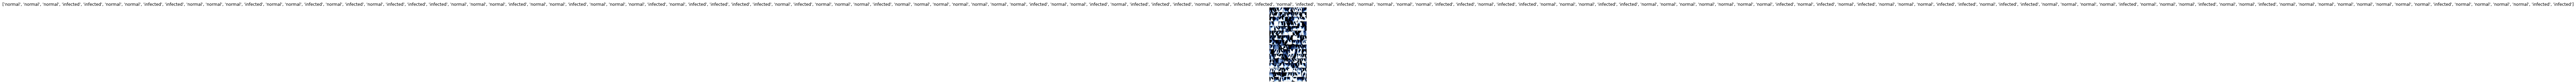

In [19]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

### Load pre-trained VGG-16

In [20]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
print(vgg16.classifier[3])

Linear(in_features=4096, out_features=4096, bias=True)


### Removing Last Layer

In [22]:
vgg16.classifier[0].out_features = 760
vgg16.classifier[3].in_features = 760
vgg16.classifier[3].out_features = 2

num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-3] # Remove last layer
##features = ([nn.Linear(25088,760),nn.ReLU(inplace=True),nn.Linear(760,2)])
print(features)

[Linear(in_features=25088, out_features=760, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=760, out_features=2, bias=True)]


### Freezing the layers

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.requires_grad = False

### Adding New Layer

In [0]:
##features.extend([nn.Linear(num_features, len(class_names))])

In [24]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Loss function and optimizer

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9
                      )

### Training

In [28]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    running_loss_valid = 0.0
    pbar_valid = tqdm(enumerate(validationloader))
    for i, data in pbar_valid:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss_valid += loss.item()
        
        pbar_valid.set_description(
            'Valid Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validationloader.dataset),
                100. * i / len(validationloader),
                loss.item()))
        
    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')

print('Finished Training')



0it [00:00, ?it/s]

Train Epoch: 0 [0/12000 (0%)]	Loss: 0.857609: : 0it [00:03, ?it/s]

Train Epoch: 0 [0/12000 (0%)]	Loss: 0.857609: : 1it [00:03,  3.42s/it]

Train Epoch: 0 [128/12000 (1%)]	Loss: 0.489838: : 1it [00:06,  3.42s/it]

Train Epoch: 0 [128/12000 (1%)]	Loss: 0.489838: : 2it [00:06,  3.36s/it]

Train Epoch: 0 [256/12000 (2%)]	Loss: 0.486003: : 2it [00:09,  3.36s/it]

Train Epoch: 0 [256/12000 (2%)]	Loss: 0.486003: : 3it [00:09,  3.34s/it]

Train Epoch: 0 [384/12000 (3%)]	Loss: 0.893260: : 3it [00:13,  3.34s/it]

Train Epoch: 0 [384/12000 (3%)]	Loss: 0.893260: : 4it [00:13,  3.32s/it]

Train Epoch: 0 [512/12000 (4%)]	Loss: 0.700995: : 4it [00:16,  3.32s/it]

Train Epoch: 0 [512/12000 (4%)]	Loss: 0.700995: : 5it [00:16,  3.29s/it]

Train Epoch: 0 [640/12000 (5%)]	Loss: 0.615835: : 5it [00:19,  3.29s/it]

Train Epoch: 0 [640/12000 (5%)]	Loss: 0.615835: : 6it [00:19,  3.28s/it]

Train Epoch: 0 [768/12000 (6%)]	Loss: 0.568690: : 6it [00:22,  3.28s/it]

Train Epoch: 0 [768/1200

Finished Training


In [0]:
from tqdm import tqdm
from sklearn.metrics import plot_confusion_matrix
        

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

targets = []
all_predicts = []


for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        #input_max, input_indexes = torch.max(input, dim=1)
        #predicted=torch.max(outputs.data,import_max)
              
        
        # print statistics
        running_loss += loss.item()

        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        torch.save(vgg16.state_dict(), 'vgg16_ft.pth')

        #targets += list( labels.view(-1).cpu().numpy())
        #all_predicts += (list(predicted.view(-1).cpu().numpy()))
        

#cm = confusion_matrix(y_true=targets,y_pred=all_predocts)
#print(cm)

plt.title("Loss curve")
plt.plot(range(Epochs), meanTerror)
plt.plot(range(Epochs), meanVerror)
plt.show()

plt.title("Accuracy Curve")
plt.plot(range(Epochs), meanTrain)
plt.plot(range(Epochs), meanValid)
plt.show()    

print('Finished Training')








0it [00:00, ?it/s]






Train Epoch: 0 [0/12000 (0%)]	Loss: 0.588600: : 0it [00:02, ?it/s]






Train Epoch: 0 [0/12000 (0%)]	Loss: 0.588600: : 1it [00:03,  3.20s/it]






Train Epoch: 0 [128/12000 (1%)]	Loss: 0.569924: : 1it [00:06,  3.20s/it]






Train Epoch: 0 [128/12000 (1%)]	Loss: 0.569924: : 2it [00:06,  3.20s/it]






Train Epoch: 0 [256/12000 (2%)]	Loss: 0.571559: : 2it [00:09,  3.20s/it]






Train Epoch: 0 [256/12000 (2%)]	Loss: 0.571559: : 3it [00:09,  3.20s/it]






Train Epoch: 0 [384/12000 (3%)]	Loss: 0.530692: : 3it [00:12,  3.20s/it]






Train Epoch: 0 [384/12000 (3%)]	Loss: 0.530692: : 4it [00:12,  3.22s/it]






Train Epoch: 0 [512/12000 (4%)]	Loss: 0.566996: : 4it [00:15,  3.22s/it]






Train Epoch: 0 [512/12000 (4%)]	Loss: 0.566996: : 5it [00:16,  3.21s/it]






Train Epoch: 0 [640/12000 (5%)]	Loss: 0.526537: : 5it [00:18,  3.21s/it]






Train Epoch: 0 [640/12000 (5%)]	Loss: 0.526537: : 6it [00:19,  3.17s/it]






Train Epoch: 0 [768/12000 (6